In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter

In [3]:
# Настройка рабочего стола и вывода инфы в пандас
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.options.display.max_columns = 20
pd.options.display.precision = 7
pd.options.display.max_colwidth = 50

## Со столбцами №скв, Нэфф общие, ННТ, с ГРП или нет (кол-во стадий), ГС/НСС, длина ГС (если ГС), стартовые дебиты нефти и жидкости, темпы падения нефти и жидкости, обводненность.

In [8]:
mer_init = pd.read_csv('../all_mers/nng_mur_mer_20230519.csv', encoding = 'cp1251', sep = ';')
rigis_init = pd.read_csv('../all_mers/nng_mur_rigis_20230519.csv', encoding = 'cp1251', sep = ';')
addinfo_init = pd.read_csv('../all_mers/nng_mur_addinfo_20230519.csv', encoding = 'cp1251', sep = ';')
frac_init = pd.read_csv('../all_mers/nng_mur_frac_20230530.csv', encoding = 'cp1251', sep = ';')
pad_coord_init = pd.read_csv('../all_mers/nng_mur_padcoord_20230522.csv', encoding = 'cp1251', sep = ';')

In [9]:
mer = mer_init.copy()
rigis = rigis_init.copy()
addinfo = addinfo_init.copy()
frac = frac_init.copy()
pad_coord = pad_coord_init.copy()

In [10]:
pad_coord

,oil_field,pad_num,x_center,y_center,well
0,Вынгапуровское,КУСТ-117,592776.777,6951213.266,3108
1,Вынгапуровское,КУСТ-117,592776.777,6951213.266,3109
2,Вынгапуровское,КУСТ-117,592776.777,6951213.266,3110
3,Вынгапуровское,КУСТ-117,592776.777,6951213.266,3111
4,Вынгапуровское,КУСТ-117,592776.777,6951213.266,3112
...,...,...,...,...,...
43769,Северо-Покурское,КУСТ-58,531717.377,6779496.485,1509
43770,Северо-Покурское,КУСТ-58,531717.377,6779496.485,1509Л
43771,Северо-Покурское,КУСТ-58,531717.377,6779496.485,1510
43772,Северо-Покурское,КУСТ-58,531717.377,6779496.485,1511


### Загрузка и подготовка инфы по типу скважин

In [7]:
addinfo_sug = addinfo[addinfo.oil_field=='Сугмутское']
addinfo_sug['uwi'] = addinfo.oil_field + '_' + addinfo.wellbore 
addinfo_sug = addinfo_sug[['uwi','borehole_type']]
# addinfo_sug_hrz = addinfo_sug[addinfo_sug.borehole_type == 'горизонтал.']
# addinfo_sug_hrz_lst = addinfo_sug_hrz['uwi']
addinfo_init

,oil_field,wellbore,plast,borehole_type,project_destination_current
0,Вынгапуровское,712f,NaN,наклон-направлен.,НЕФ
1,Вынгапуровское,712Г,БВ8/1,горизонтал.,НЕФ
2,Вынгапуровское,713,NaN,наклон-направлен.,НЕФ
3,Вынгапуровское,714,NaN,наклон-направлен.,НЕФ
4,Вынгапуровское,715,NaN,наклон-направлен.,НЕФ
...,...,...,...,...,...
21861,Суторминское,888,NaN,наклон-направлен.,НАГ
21862,Суторминское,8881,NaN,наклон-направлен.,НЕФ
21863,Суторминское,8882,NaN,наклон-направлен.,НЕФ
21864,Суторминское,8883,NaN,наклон-направлен.,НЕФ


### Подготовка инфы по фракам для ННС

In [7]:
frac_sug = frac[frac.oil_field=='Сугмутское']
frac_sug['uwi'] = frac_sug.oil_field + '_' + frac_sug.wellbore
frac_sug = frac_sug[['uwi','oil_field', 'wellbore', 'contractor', 'frac_date', 'layer', 'net_pay',
       'braker', 'proppant_total', 'pad', 'proppant_laden_fluid_without_p',
       'geled_fluid_total', 'max_concentration', 'proppants', 'remarks',
       'perf_top', 'perf_bottom', 'xf', 'hf', 'wf', 'pi_design', 'skin', 'jd',
       'fcd', 'gross_pay', 'designed_proppant_total', 'rcp_proppant',
       'fluid_efficiency', 'rate', 'permeability', 'shut_pressure',
       'deviation', 'horner_form_pressure']]
frac_sug_bt = frac_sug.set_index('uwi').join(addinfo_sug.set_index('uwi')).reset_index()
frac_sug_nns = frac_sug_bt[frac_sug_bt.borehole_type != 'горизонтал.']
frac_sug_nns_prop = frac_sug_nns.groupby('uwi')['proppant_total'].apply(lambda x: list(round(x,0))).reset_index()
frac_sug_nns_cont = frac_sug_nns.groupby('uwi')['contractor'].apply(lambda x: list(x)).reset_index()
frac_sug_nns_date = frac_sug_nns.groupby('uwi')['frac_date'].apply(lambda x: list(x)).reset_index()
frac_sug_nns_fnl = frac_sug_nns_prop.set_index('uwi').join(frac_sug_nns_cont.set_index('uwi')).reset_index()
frac_sug_nns_fnl = frac_sug_nns_fnl.set_index('uwi').join(frac_sug_nns_date.set_index('uwi')).reset_index()
# frac_sug_nns_fnl

### Подготовка датасета с ригис и разделение на ННС и ГС

In [8]:
rigis_work = rigis[['oil_field','wellbore', 'agk', 'ankt', 'aps', 'collector','lit', 'h', 'habs', 'l', 'labs', 'ro', 'kgas', 'kgl', 'kn', 'kplast', 'kpor', 'kpr', 'sat1']]
rigis_sug = rigis_work[rigis_work.oil_field == 'Сугмутское']
rigis_sug.sort_values(by='wellbore', inplace=True)
rigis_sug['uwi'] = rigis_sug.oil_field + '_' + rigis_sug.wellbore
rigis_sug = rigis_sug[['uwi','kplast','agk', 'ankt', 'aps', 'collector','lit','sat1','h', 'habs', 'l', 'labs','ro', 'kgas', 'kgl', 'kn', 'kpor', 'kpr']]
rigis_sug = rigis_sug.set_index('uwi').join(addinfo_sug.set_index('uwi'))
rigis_sug_nns = rigis_sug[rigis_sug.borehole_type!='горизонтал.']
# rigis_sug_nns

### Определение Нобщ и Нэфф для ННС

In [9]:
rigis_sug_bs92res = rigis_sug_nns[(rigis_sug_nns.kplast == 'БС9-2-1+2') & (rigis_sug_nns.collector == 1) ]
rigis_sug_bs92net = rigis_sug_nns[(rigis_sug_nns.kplast == 'БС9-2-1+2') & (rigis_sug_nns.collector == 1) & (rigis_sug_nns.sat1 == 'Н') ]
sug_bs92_nns_htot = rigis_sug_bs92res.groupby('uwi')['labs'].sum().reset_index()
sug_bs92_nns_htot.rename(columns={'labs':'htot'}, inplace=True)
sug_bs92_nns_heff = rigis_sug_bs92net.groupby('uwi')['labs'].sum().reset_index()
sug_bs92_nns_heff.rename(columns={'labs':'heff'}, inplace=True)

### Формирование датафрейма по МЭР для ННС

In [10]:
mer['date_'] = pd.to_datetime(mer['date_'], dayfirst=True)
mer_sug_oil = mer[(mer.oil_field=='Сугмутское') & (mer.kcharwork=='НЕФ')]
mer_sug_oil['uwi'] = mer_sug_oil.oil_field + '_' + mer_sug_oil.wellbore
mer_sug_oil = mer_sug_oil[['uwi','oil_field', 'wellbore', 'date_', 'kplast', 'kcharwork', 'method',
       'worktime', 'colltime', 'staytime', 'oil', 'wat', 'kagentprod']]
mer_sug_oil.sort_values(by=['wellbore','date_'], inplace=True)

### Поиск скважин, которые отработали 3/4 месяца и взятие 1го замера, где выполняется это условие. Колонка ранга введена для понимания на каком месяце скважина начала работать

In [49]:
mer_sug_oil_brf = mer_sug_oil[['uwi','date_','kplast','worktime','oil','wat']]
mer_sug_oil_brf['rank'] = mer_sug_oil_brf.groupby('uwi')['date_'].rank(method='first')
mer_sug_oil_gb = mer_sug_oil_brf[mer_sug_oil_brf.worktime > 24*30*3/4].groupby('uwi').apply(lambda x: x.iloc[0])
mer_sug_oil_gb.drop('uwi', axis=1, inplace=True)

1. разделить скважины на ГС и ННС +
2. посчитать отдельно ннт и общ толщ для ГС и ННС - + 
3. проверить скважины с ГРП + 
4. взять отдельно стартовые дебиты для ННС +
5. как считать темпы падения? максимальный дебит и дебит чз 12 мес например, считаем разницу
6. посчитать длины ГС скважин
7. найти для ГС данные ГРП и добычу

### Формирование финальной таблицы

In [50]:
sug_bs92_final1 = sug_bs92_nns_htot.set_index('uwi').join(sug_bs92_nns_heff.set_index('uwi')).reset_index()
sug_bs92_final2 = sug_bs92_final1.set_index('uwi').join(addinfo_sug.set_index('uwi'), how='inner').reset_index()
sug_bs92_final3 = sug_bs92_final2.set_index('uwi').join(frac_sug_nns_fnl.set_index('uwi')).reset_index()
sug_bs92_final4 = sug_bs92_final3.set_index('uwi').join(mer_sug_oil_gb).reset_index()

In [51]:
sug_bs92_final4['oil_tpd'] = ((sug_bs92_final4.oil/sug_bs92_final4.worktime)*24).round(0)
sug_bs92_final4['wat_tpd'] = ((sug_bs92_final4.wat/sug_bs92_final4.worktime)*24).round(0)
sug_bs92_final4['wc'] = (sug_bs92_final4.wat_tpd/(sug_bs92_final4.wat_tpd + sug_bs92_final4.oil_tpd)).round(2)
sug_bs92_final5 = sug_bs92_final4[['uwi', 'htot', 'heff', 'borehole_type', 'frac_date','proppant_total', 'date_', 'kplast', 'rank','oil_tpd', 'wat_tpd', 'wc']]
sug_bs92_final5

,uwi,htot,heff,borehole_type,frac_date,proppant_total,date_,kplast,rank,oil_tpd,wat_tpd,wc
0,Сугмутское_1,6.10,6.10,наклон-направлен.,"[16.10.2007, 28.10.2007, 29.04.2015, 29.04.201...","[0.0, 71.0, 1.0, 50.0, 50.0]",2008-01-01,БС9/2,3.0,20.0,56.0,0.74
1,Сугмутское_1006PL,4.49,1.72,наклон-направлен.,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,Сугмутское_1007,5.90,3.40,наклон-направлен.,[15.05.2003],[7.0],NaT,NaN,NaN,NaN,NaN,NaN
3,Сугмутское_1010,7.56,6.96,наклон-направлен.,[16.04.2003],[51.0],NaT,NaN,NaN,NaN,NaN,NaN
4,Сугмутское_1031PL,5.36,4.11,наклон-направлен.,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
835,Сугмутское_473P,38.40,NaN,наклон-направлен.,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
836,Сугмутское_476P,1.00,1.00,вертикал.,"[22.04.2003, 11.10.2012]","[36.0, 60.0]",2003-05-01,БС9/2,19.0,35.0,3.0,0.08
837,Сугмутское_477P,8.20,NaN,наклон-направлен.,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
838,Сугмутское_478ПО,46.16,6.79,вертикал.,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [45]:
# проверка почему есть фрак и ннт, но нет добычи
# sug_bs92_final5[(sug_bs92_final5.frac_date.notna()) & (sug_bs92_final5.oil_tpd.isna())].reset_index()
# mer_sug_oil_brf[mer_sug_oil_brf.uwi == 'Сугмутское_1910'] - почему то скважины реально без добычи, почему непонятно, надо проверить по номеру скважины в большом МЭР
# mer_sug_oil_brf[mer_sug_oil_brf.uwi.str.contains('2011')] - если есть индекс _1, то скважина просто работает на другой ствол, возможно надо сделать привязку стволов чз координаты устья

### Анализ темпов падения нефти и жидкости по МЭР для ННС 

In [60]:
# mer_sug_oil_brf_test
mer_sug_oil_brf_test = mer_sug_oil_brf.copy()
mer_sug_oil_brf_test['oil_tpd'] = ((mer_sug_oil_brf_test.oil/mer_sug_oil_brf_test.worktime)*24).round(0)
mer_sug_oil_brf_test['wat_tpd'] = ((mer_sug_oil_brf_test.wat/mer_sug_oil_brf_test.worktime)*24).round(0)
mer_sug_oil_brf_test['wc'] = (mer_sug_oil_brf_test.wat_tpd/(mer_sug_oil_brf_test.wat_tpd + mer_sug_oil_brf_test.oil_tpd)).round(2)
mer_sug_oil_brf_test['rank_mer'] = mer_sug_oil_brf_test.groupby('uwi')['date_'].rank(method='first').astype('int')
mer_sug_oil_brf_test

,uwi,date_,kplast,worktime,oil,wat,rank,oil_tpd,wat_tpd,wc,rank_mer
2465807,Сугмутское_1,2007-11-01,БС9/2,528.0,1034.0,1713.0,1.0,47.0,78.0,0.62,1
2465827,Сугмутское_1,2007-12-01,БС9/2,303.0,382.0,852.0,2.0,30.0,67.0,0.69,2
2465642,Сугмутское_1,2008-01-01,БС9/2,744.0,626.0,1725.0,3.0,20.0,56.0,0.74,3
2465657,Сугмутское_1,2008-02-01,БС9/2,422.0,233.0,1061.0,4.0,13.0,60.0,0.82,4
2465672,Сугмутское_1,2008-03-01,БС9/2,744.0,649.0,1890.0,5.0,21.0,61.0,0.74,5
...,...,...,...,...,...,...,...,...,...,...,...
2975601,Сугмутское_478ПО,2022-12-01,БС9/2,0.0,0.0,0.0,254.0,NaN,NaN,NaN,254
6091213,Сугмутское_478ПО,2023-01-01,БС9/2,0.0,0.0,0.0,255.0,NaN,NaN,NaN,255
6024086,Сугмутское_478ПО,2023-02-01,БС9/2,0.0,0.0,0.0,256.0,NaN,NaN,NaN,256
6068209,Сугмутское_478ПО,2023-03-01,БС9/2,0.0,0.0,0.0,257.0,NaN,NaN,NaN,257


In [98]:
print('Общее количество скважин в МЭР:',len(mer_sug_oil_brf_test.uwi.unique()))
print('Общее количество скважин с МЭР длинной 12мес и больше:',len(mer_sug_oil_brf_test[mer_sug_oil_brf_test.rank_mer==13].uwi.unique()))

Общее количество скважин в МЭР: 884
Общее количество скважин с МЭР длинной 12мес и больше: 734


In [119]:
mer_sug_oil_brf_test13_wells = mer_sug_oil_brf_test[mer_sug_oil_brf_test.rank_mer==13].uwi.unique()
mer_sug_oil_brf_test13 = mer_sug_oil_brf_test[mer_sug_oil_brf_test.uwi.isin(mer_sug_oil_brf_test13_wells)]
mer_sug_oil_brf_test13 # поиск скважин, где меров больше чем за год

,uwi,date_,kplast,worktime,oil,wat,rank,oil_tpd,wat_tpd,wc,rank_mer
2465807,Сугмутское_1,2007-11-01,БС9/2,528.0,1034.0,1713.0,1.0,47.0,78.0,0.62,1
2465827,Сугмутское_1,2007-12-01,БС9/2,303.0,382.0,852.0,2.0,30.0,67.0,0.69,2
2465642,Сугмутское_1,2008-01-01,БС9/2,744.0,626.0,1725.0,3.0,20.0,56.0,0.74,3
2465657,Сугмутское_1,2008-02-01,БС9/2,422.0,233.0,1061.0,4.0,13.0,60.0,0.82,4
2465672,Сугмутское_1,2008-03-01,БС9/2,744.0,649.0,1890.0,5.0,21.0,61.0,0.74,5
...,...,...,...,...,...,...,...,...,...,...,...
2975601,Сугмутское_478ПО,2022-12-01,БС9/2,0.0,0.0,0.0,254.0,NaN,NaN,NaN,254
6091213,Сугмутское_478ПО,2023-01-01,БС9/2,0.0,0.0,0.0,255.0,NaN,NaN,NaN,255
6024086,Сугмутское_478ПО,2023-02-01,БС9/2,0.0,0.0,0.0,256.0,NaN,NaN,NaN,256
6068209,Сугмутское_478ПО,2023-03-01,БС9/2,0.0,0.0,0.0,257.0,NaN,NaN,NaN,257


In [288]:
well_test = 'Сугмутское_1739'
max_per_well = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == well_test) & 
                                      (mer_sug_oil_brf_test13.rank_mer < 13)].groupby('uwi')['oil_tpd'].max().iloc[0]
rank_of_max = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == well_test) & 
                                     (mer_sug_oil_brf_test13.oil_tpd == max_per_well)]['rank_mer'].iloc[0]
min_per_well = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == well_test) & (mer_sug_oil_brf_test13.rank_mer > rank_of_max) &
                                      (mer_sug_oil_brf_test13.rank_mer < 13)].groupby('uwi')['oil_tpd'].min().iloc[0]
rank_of_min = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == well_test) & 
                                     (mer_sug_oil_brf_test13.oil_tpd == min_per_well)]['rank_mer'].iloc[0]
well_oiltpd_norm = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == well_test) & (mer_sug_oil_brf_test13.rank_mer < 13)]
well_oiltpd_norm['oil_tpd_norm'] = (well_test_sel.oil_tpd - min_per_well) / (max_per_well - min_per_well)
# well_oiltpd_norm

- надо грид через 1 ранг сделать +
- посчитать макс и мин значения за год работы +
- выбрать скважины, которые не выдавали бы ошибку
- или написать обработку ошибок
- найти данные по кустам скважин
- просуммировать добычу по кусту для ННС и ГС отдельно

In [338]:
oil_norm

Series([], Name: oil_tpd_norm, dtype: float64)

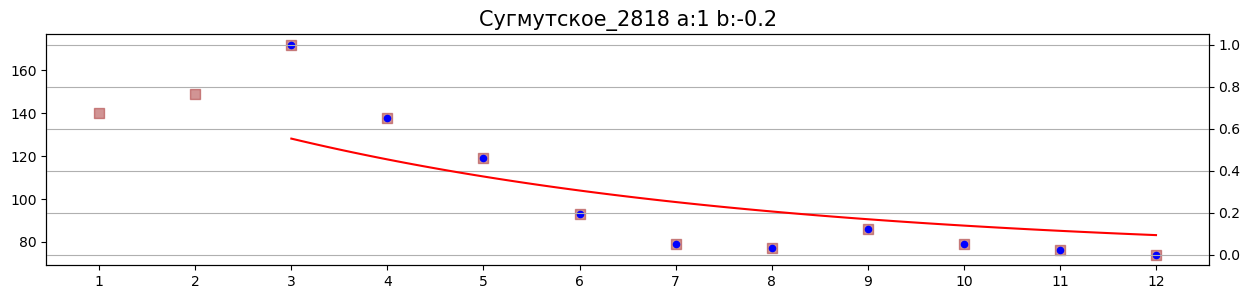

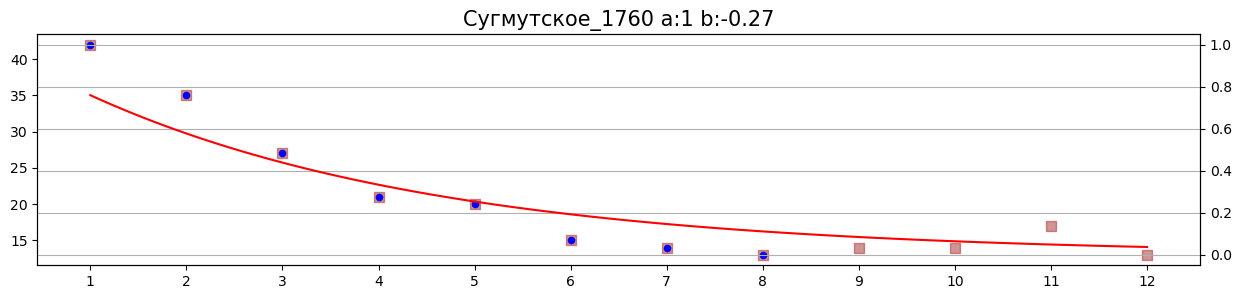

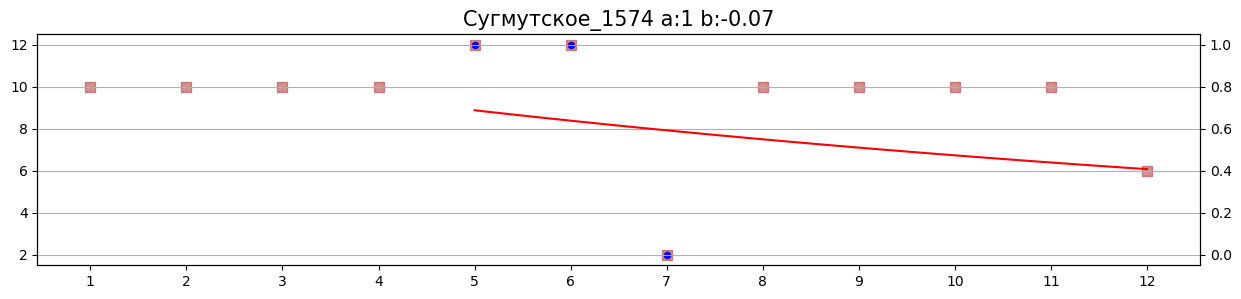

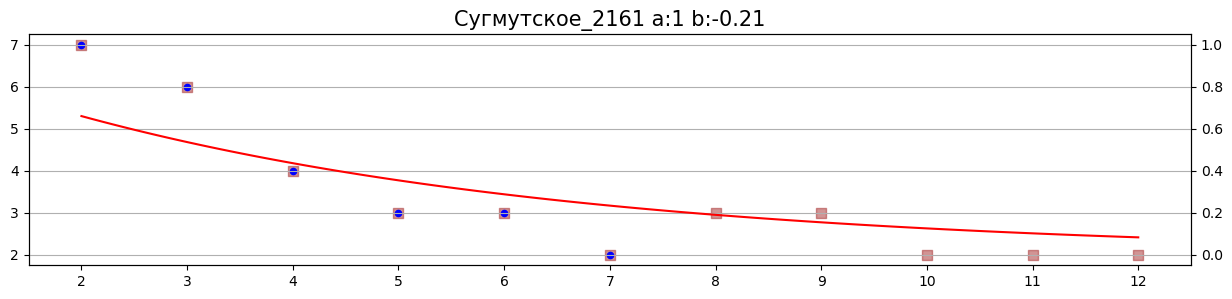

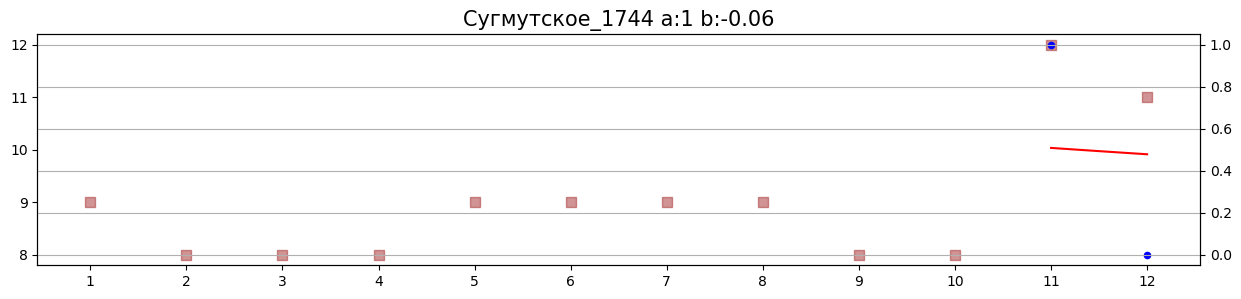

In [370]:
# Строки кода для отображения диаграмм МЭРов
for uwi in np.random.choice(mer_sug_oil_brf_test13.uwi.unique(),5):
    f, ax= plt.subplots(figsize=(15,3))
    oil = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.rank_mer < 13)]['oil_tpd']
    rank = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.rank_mer < 13)]['rank_mer']
    
    max_per_well = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.rank_mer < 13)].groupby('uwi')['oil_tpd'].max().iloc[0]
    rank_of_max = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.oil_tpd == max_per_well)]['rank_mer'].iloc[0]
    min_per_well = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & 
                                          (mer_sug_oil_brf_test13.rank_mer > rank_of_max) & (mer_sug_oil_brf_test13.rank_mer < 13)].groupby('uwi')['oil_tpd'].min().iloc[0]
    rank_of_min = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.oil_tpd == min_per_well)]['rank_mer'].iloc[0]
    oil_for_approx = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.rank_mer.between(rank_of_max, rank_of_min))]['oil_tpd']
    rank_for_approx = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & 
                                             (mer_sug_oil_brf_test13.rank_mer.between(rank_of_max, rank_of_min, inclusive='both'))]['rank_mer']
    
    well_oiltpd_norm = mer_sug_oil_brf_test13[(mer_sug_oil_brf_test13.uwi == uwi) & (mer_sug_oil_brf_test13.rank_mer < 13)]
    well_oiltpd_norm['oil_tpd_norm'] = (mer_sug_oil_brf_test13.oil_tpd - min_per_well) / (max_per_well - min_per_well)
    oil_norm = well_oiltpd_norm[(well_oiltpd_norm.uwi == uwi) & (well_oiltpd_norm.rank_mer.between(rank_of_max, rank_of_min))]['oil_tpd_norm']
    rank_norm = well_oiltpd_norm[(well_oiltpd_norm.uwi == uwi) & 
                                             (well_oiltpd_norm.rank_mer.between(rank_of_max, rank_of_min, inclusive='both'))]['rank_mer']
    
    [b], res1 = curve_fit(lambda x1,b: 1*numpy.exp(b*x1),  rank_norm,  oil_norm)
    a=1
    rank_norm_spline = np.linspace(rank_of_max, 12, 100)
    y1_spline = 1 * numpy.exp(b * rank_norm_spline)
    
    ax.scatter(rank, oil, c='brown', marker='s', s=50, alpha=0.5)
    ax2 = ax.twinx()
    ax2.scatter(rank_norm, oil_norm, c='blue', marker='o', s=20)
    ax2.plot(rank_norm_spline, y1_spline, 'r')
    tick_spacing = 1
    ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))
    ax.set_title(uwi + ' a:' + str(round(a,2)) + ' b:' + str(round(b,2)), fontsize=15)
    ax2.grid();

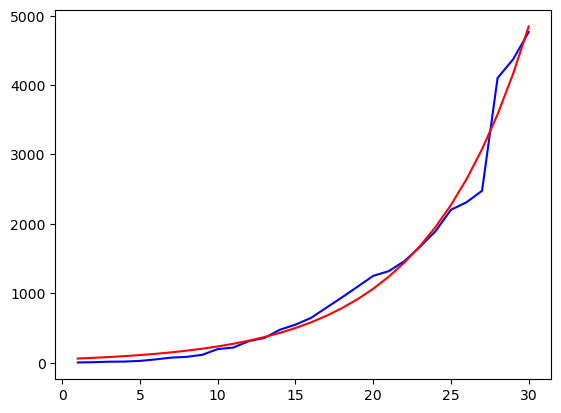

51.49454013304972 0.15147130865577693 [[ 7.22151986e+01 -5.08636433e-02]
 [-5.08636433e-02  3.63445665e-05]]


In [327]:
# экспоненциальную функцию нашел в инете по адресу https://svitla.com/blog/approximation-data-by-exponential-function-on-python
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
x = numpy.arange(1, 31, 1)
y = numpy.array([3,7,14,16,26,47,73,84,113,196,218,310,356,475,548,645,794,
            942,1096,1251,1319,1462,1668,1892,2203,2311,2477,4102,4372,4764])

def model_exp (x1,a,b):
    return a*numpy.exp(b*x1)
[a, b], res1 = curve_fit(model_exp, x,  y)
y1 = a * numpy.exp(b * x)

plt.plot(x, y, 'b')
plt.plot(x, y1, 'r')
plt.show()

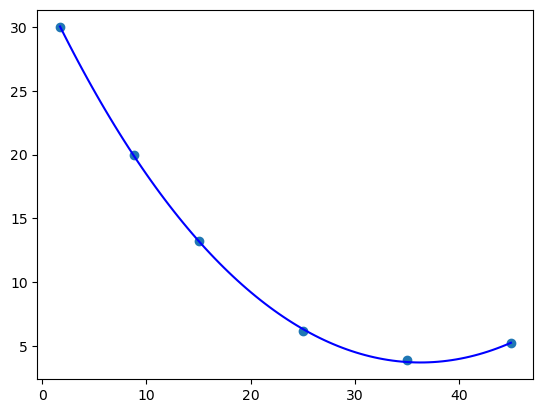

In [328]:
# гиперболическую функцию нашел в инете по адресу https://stackoverflow.com/questions/75224685/fitting-hyperbolic-cosine-curve-in-python
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.interpolate as inp

# xData = np.array([1.7, 8.8, 15, 25, 35, 45, 54.8, 60, 64.7, 70])
# yData = np.array([30, 20, 13.2, 6.2, 3.9, 5.2, 10, 14.8, 20, 27.5])

xData = np.array([1.7, 8.8, 15, 25, 35, 45 ])
yData = np.array([30, 20, 13.2, 6.2, 3.9, 5.2])

def model_hcosine(x, a, b, c, d):
    return a * np.cosh((x-d)/b) + c

poptcosh, pcovcosh = curve_fit(model_hcosine, xData, yData, p0=[min(yData), max(xData), max(yData), 0])

aapopt, bbopt, cccopt, ddopt = poptcosh
xCoshModel = np.linspace(min(xData), max(xData), 100)
yCoshModel = model_hcosine(xCoshModel, aapopt, bbopt, cccopt, ddopt)

plt.scatter(xData, yData)
plt.plot(xCoshModel, yCoshModel, 'b-')


In [ ]:
def hypRegress(ptp,pir):

    xData = np.arange(len(ptp))
    yData = pir

    xData = np.array(xData, dtype=float)
    yData = np.array(yData, dtype= float)

    def funcHyp(x, qi, exp, di):
        return qi*(1+exp*di*x)**(-1/exp)

    def errfuncHyp(p):
        return funcHyp(xData, p[0], p[1], p[2]) - yData

    #print(xData.min(), xData.max())
    #print(yData.min(), yData.max())

    trialX = np.linspace(xData[0], xData[-1], 1000)



    # Fit an hyperbolic
    popt, pcov = optimize.curve_fit(funcHyp, xData, yData)
    print 'popt'
    #print(popt)
    yHYP = funcHyp(trialX, *popt)

    #optimization

    # initial values
    p1, success = optimize.leastsq(errfuncHyp, popt,maxfev=10000)
    print p1

    aaaa = funcHyp(trialX, *p1)

    plt.figure()
    plt.plot(xData, yData, 'r+', label='Data', marker='o')
    plt.plot(trialX, yHYP, 'r-',ls='--', label="Hyp Fit")
    plt.plot(trialX, aaaa, 'y', label = 'Optimized')
    plt.legend()
    plt.show(block=False)
    return p1


def harRegress(ptp,pir):

    xData = np.arange(len(ptp))
    yData = pir

    xData = np.array(xData, dtype=float)
    yData = np.array(yData, dtype=float)

    def funcHar(x, qi, di):
        return qi*(1+di*x)**(-1)

    def errfuncHar(p):
        return funcHar(xData, p[0], p[1]) - yData

    #print(xData.min(), xData.max())
    #print(yData.min(), yData.max())

    trialX = np.linspace(xData[0], xData[-1], 1000)



    # Fit an harmonic
    popt, pcov = optimize.curve_fit(funcHar, xData, yData)
    print 'popt'
    print(popt)
    yHAR = funcHar(trialX, *popt)

    #optimization

    # initial values
    p1, success = optimize.leastsq(errfuncHar, popt,maxfev=1000)
    print p1

    aaaa = funcHar(trialX, *p1)

    plt.figure()
    plt.plot(xData, yData, 'r+', label='Data', marker='o')
    plt.plot(trialX, yHAR, 'r-',ls='--', label="Har Fit")
    plt.plot(trialX, aaaa, 'y', label = 'Optimized')
    plt.legend()
    plt.show(block=False)
    return p1


ptp = ([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
pir = ([150,85,90,50,45,60,60,40,40,30,28,30,38,30,26])

hypRegress(ptp,pir)
harRegress(ptp,pir)